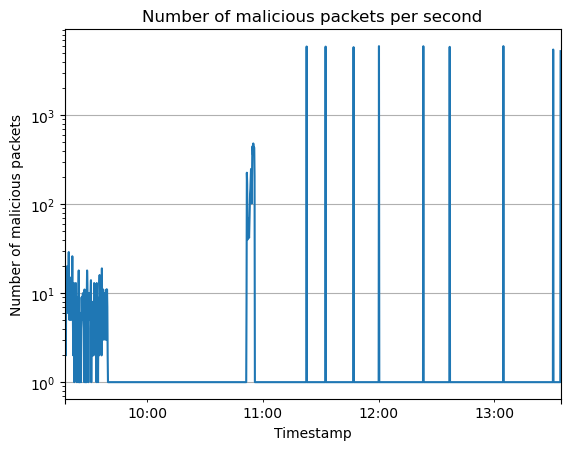

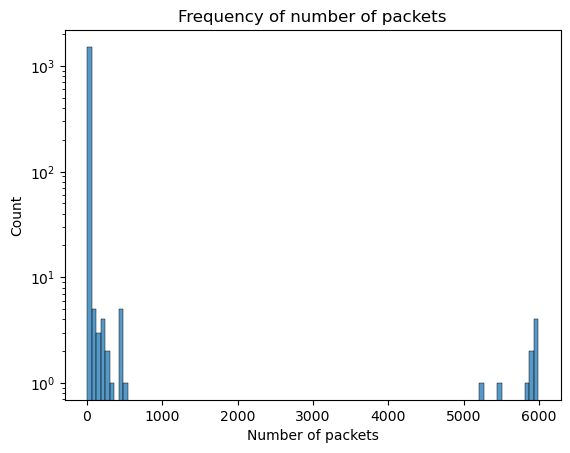

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ddos_data = pd.read_csv('ddos_dataset.csv', low_memory=False)

operational_df = ddos_data.copy()
operational_df[' Timestamp'] = pd.to_datetime(operational_df[' Timestamp'])
operational_df.set_index(' Timestamp', inplace=True)
mask_malicious = operational_df['label'] != 'benign'
df_result = operational_df[mask_malicious].resample('10S').count()

df_result['Flow ID'].replace(0, 1).plot()
plt.xlabel('Timestamp')
plt.ylabel('Number of malicious packets')
plt.yscale('log')
plt.title('Number of malicious packets per second')
plt.grid()
plt.show()

plt.figure()
sns.histplot(data=df_result.replace(0, 1), x='Flow ID', bins=100)
plt.xlabel('Number of packets')
plt.title('Frequency of number of packets')
plt.yscale('log')
plt.show()

Let's analyze the top 5 destination IP reached by attacks

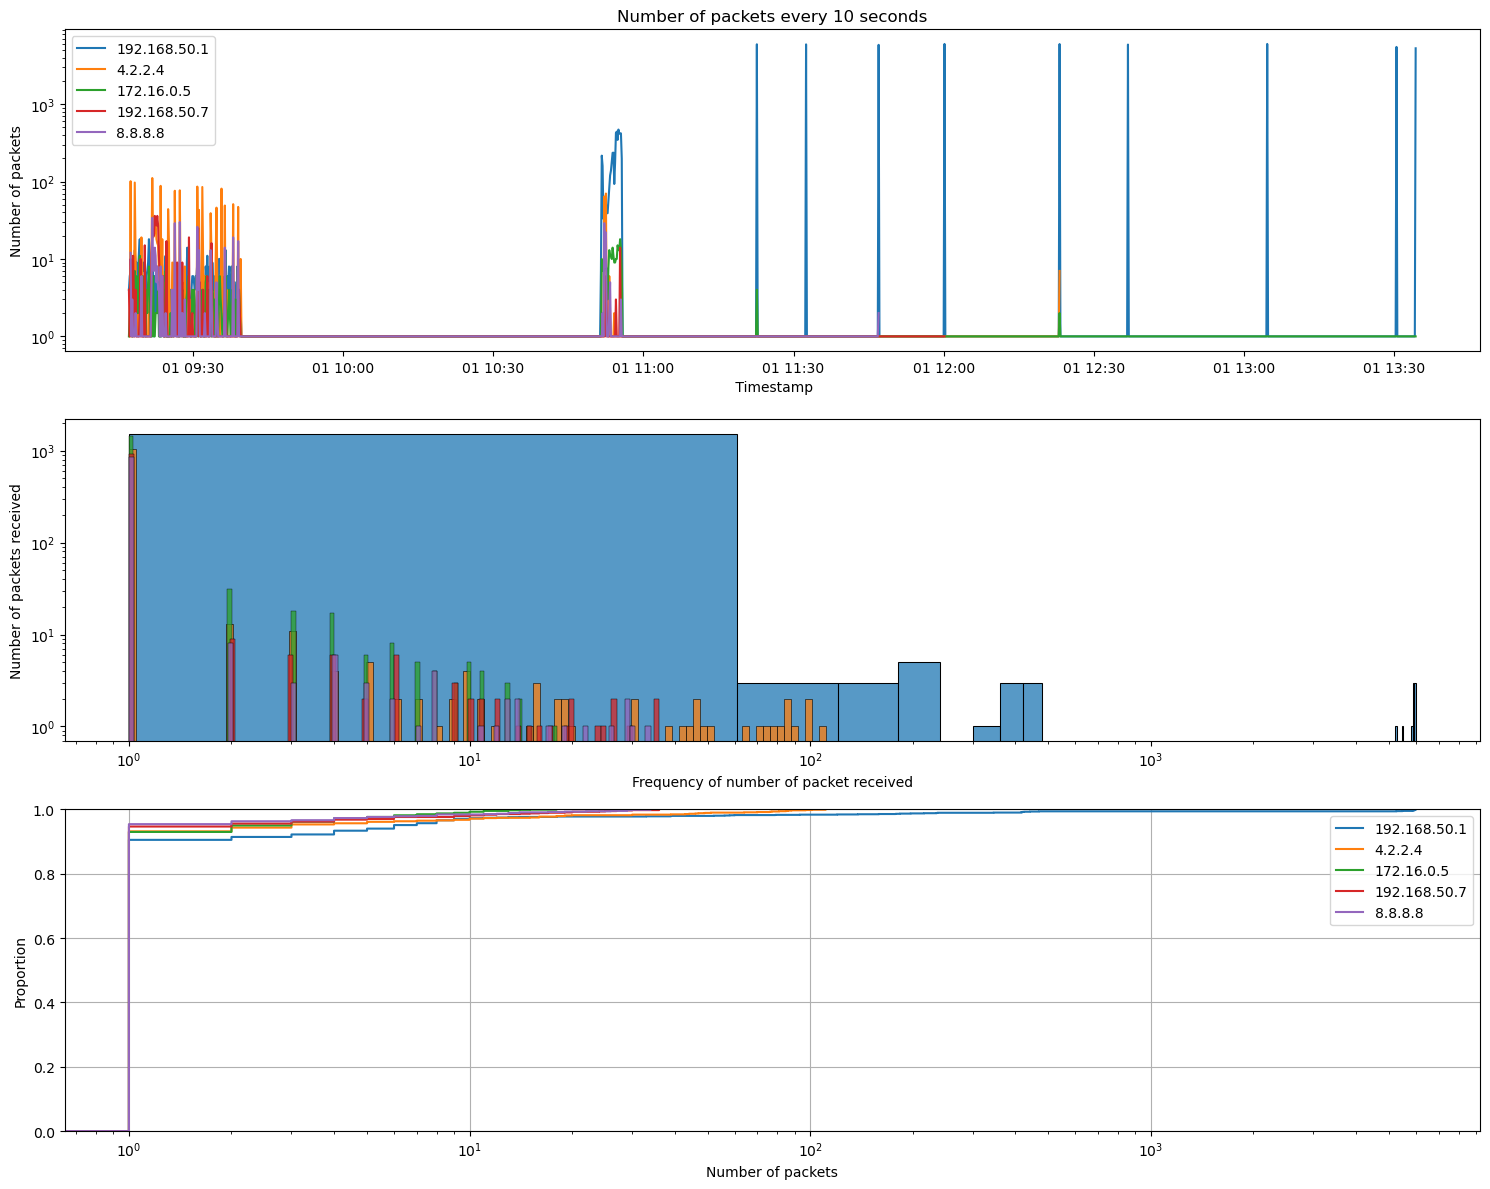

In [37]:
ip_top5 = operational_df.groupby(' Destination IP').count().sort_values(by='Flow ID', ascending=False).index[:5]
num_packets = []
t_df = operational_df.copy()
fig, ax = plt.subplots(3, 1, figsize=(15, 12))

# since I'm using a logarithmic scale I have to take care of 0 values and replace it with 1

for ip in ip_top5:
    mask_ip = t_df[' Destination IP'] == ip
    temp_df = t_df[mask_ip].resample('10S').count()
    sns.lineplot(data=temp_df.replace(0,1), y=' Destination IP', x=' Timestamp', label=ip, ax=ax[0])
    ax[0].set_title('Number of packets every 10 seconds')
    ax[0].set_ylabel('Number of packets')
    ax[0].set_yscale('log')
    sns.histplot(data=temp_df[' Destination IP'].replace(0,1), label=ip, bins=100, ax=ax[1])
    ax[1].set_ylabel('Number of packets received')
    ax[1].set_xlabel('Frequency of number of packet received')
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    sns.ecdfplot(data=temp_df[' Destination IP'].replace(0, 1), label=ip, ax=ax[2])
    ax[2].set_xlabel('Number of packets')
    ax[2].set_xscale('log')
    
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Since the top IP destination has received a lot more packets in respect of the other, let's exclude it and analyze the other 4 for a clear representation of also the othre targeted IP

 Protocol
0        18
6     11857
17    46706
Name: Flow ID, dtype: int64


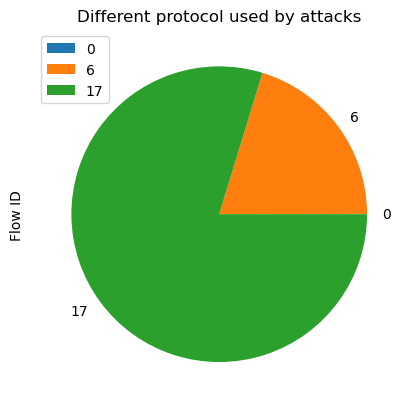

In [11]:
malicious_df = operational_df[mask_malicious].copy()
protocol_df = malicious_df.groupby(' Protocol').count()['Flow ID']
protocol_df.plot(kind='pie', title='Different protocol used by attacks')
plt.legend()
print(protocol_df)

Even if the protol 0 seems to be not used, it is indeed. This visualization is due to the fact that the count for each protocol is:<br>
0        18, <br>
6     11857, <br>
17    46706 <br>

<AxesSubplot: xlabel='label'>

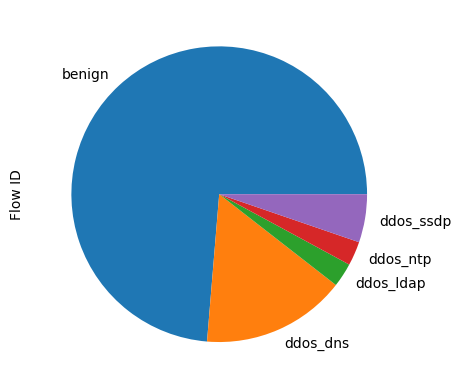

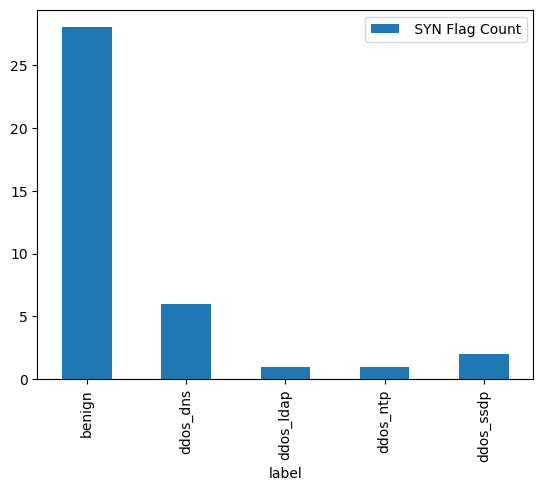

In [6]:
mask_SYN = operational_df[' SYN Flag Count'] != 0
SYN_df = operational_df[mask_SYN].groupby('label').count()['Flow ID']
SYN_df.plot(kind='pie')
at_SYN_df = operational_df[mask_SYN]
at_SYN_df[[' SYN Flag Count', 'label']].groupby('label').count().plot(kind='bar')

Now it's time to analyze the kind of attack or data flow characterized by the SYN flag high in the TCP protocol

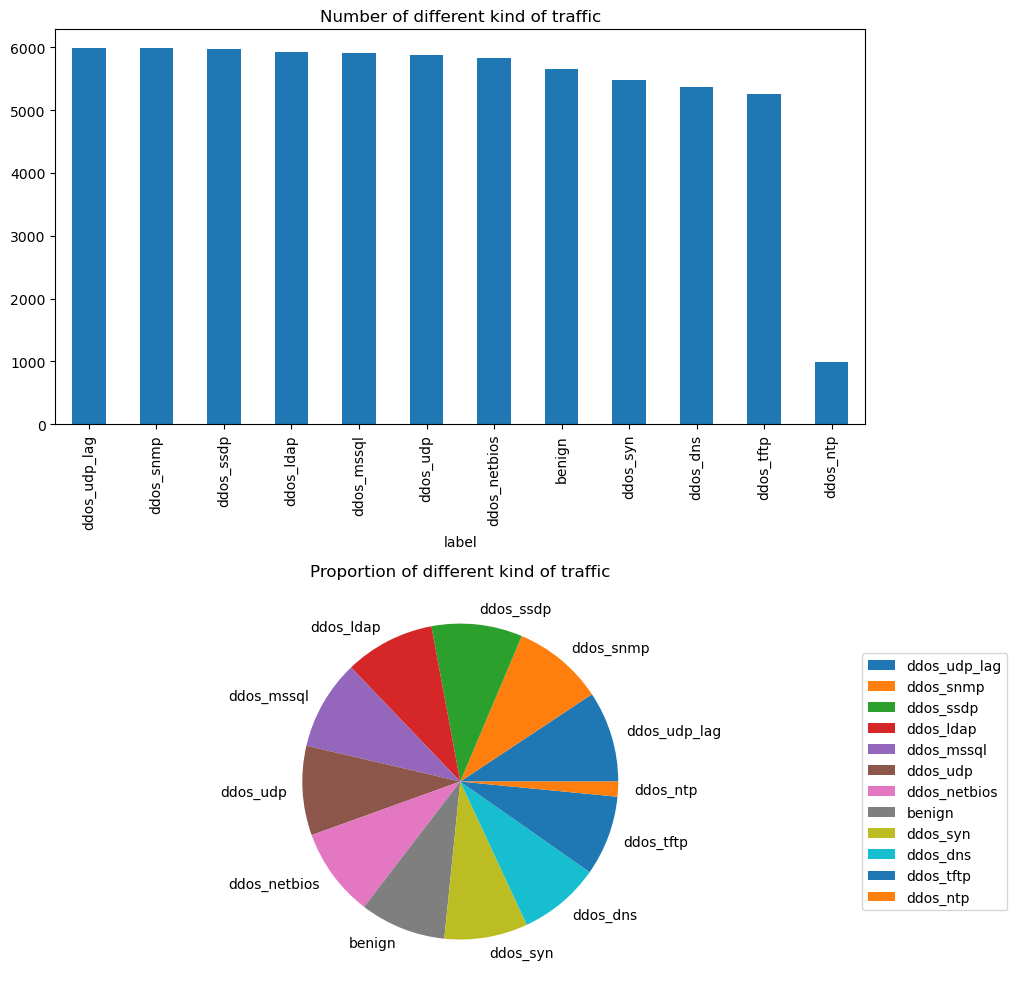

In [12]:
df_attacks = operational_df.groupby('label').count().sort_values(by='Flow ID', ascending=False)
attacks = df_attacks.index
fig, ax = plt.subplots(2,1)
df_attacks['Flow ID'].plot(kind='bar', title='Number of different kind of traffic', ax=ax[0], figsize=(10,2))
df_attacks.plot(kind='pie', y='Flow ID', ax=ax[1], title='Proportion of different kind of traffic', figsize=(10,10))
ax[1].legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
ax[1].set_ylabel('')

plt.tight_layout()

<AxesSubplot: title={'center': 'Top 10 Flow ID number of packets'}, xlabel='Flow ID'>

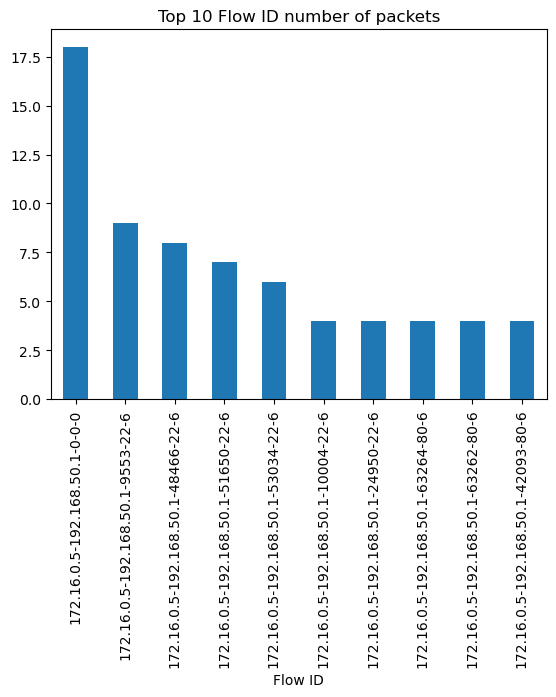

In [14]:
mask_bening = operational_df['label'] != 'benign'
df_flow_id = operational_df[mask_bening].groupby('Flow ID').count().sort_values(by=' Source IP', ascending=False)[:10]
df_flow_id[' Source IP'].plot(kind='bar', title='Top 10 Flow ID number of packets')

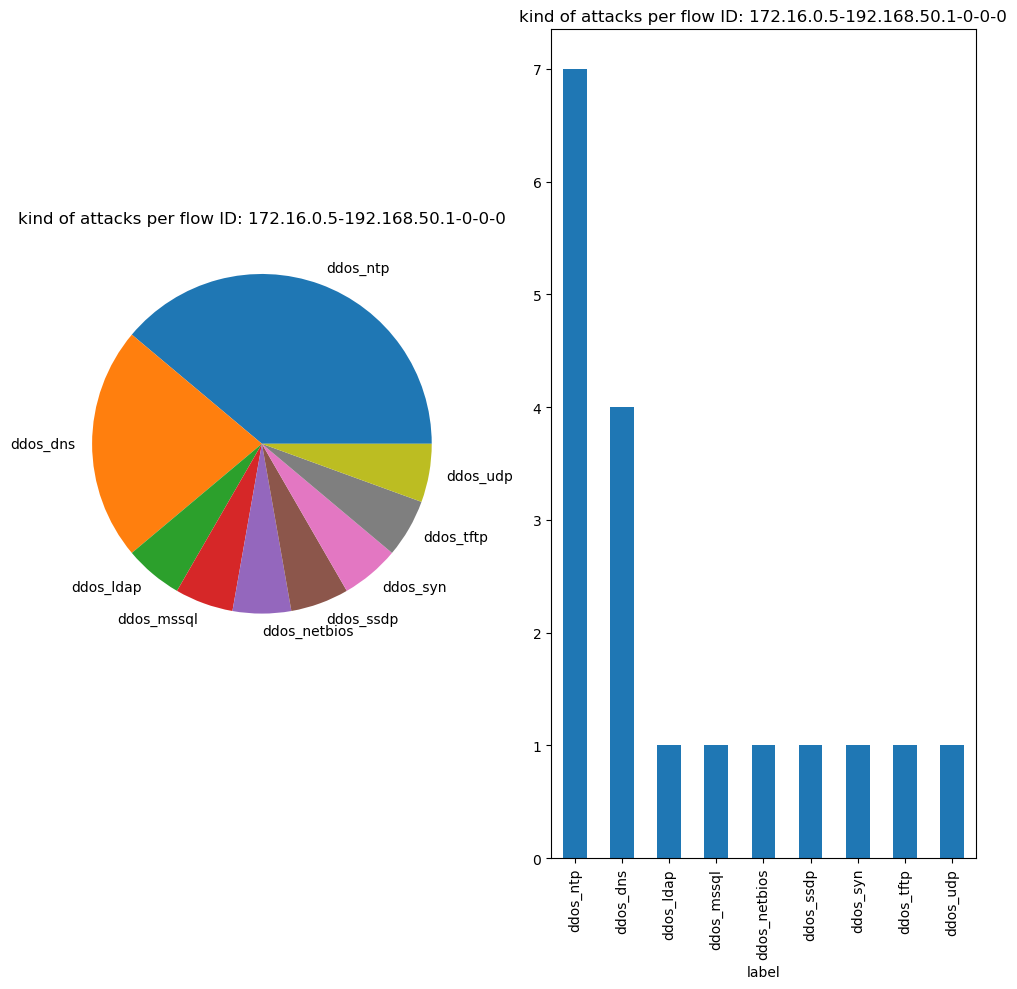

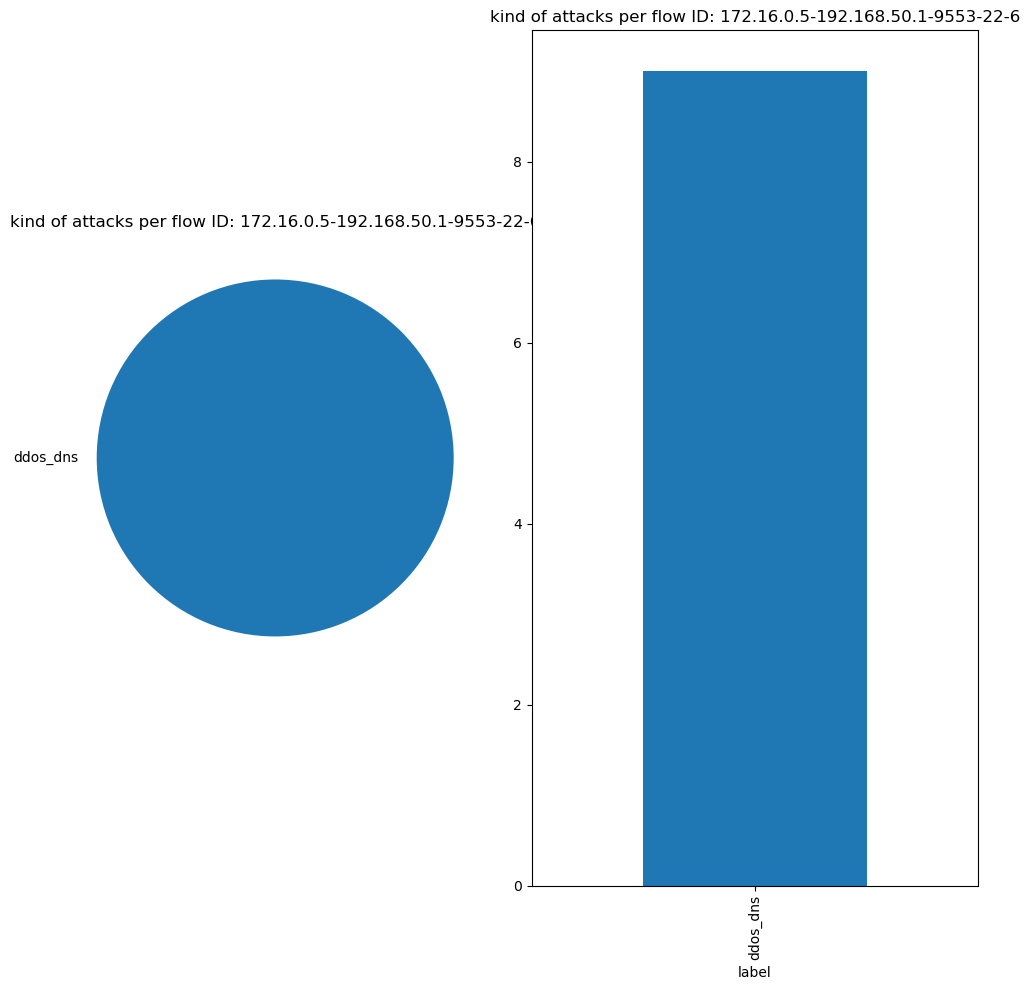

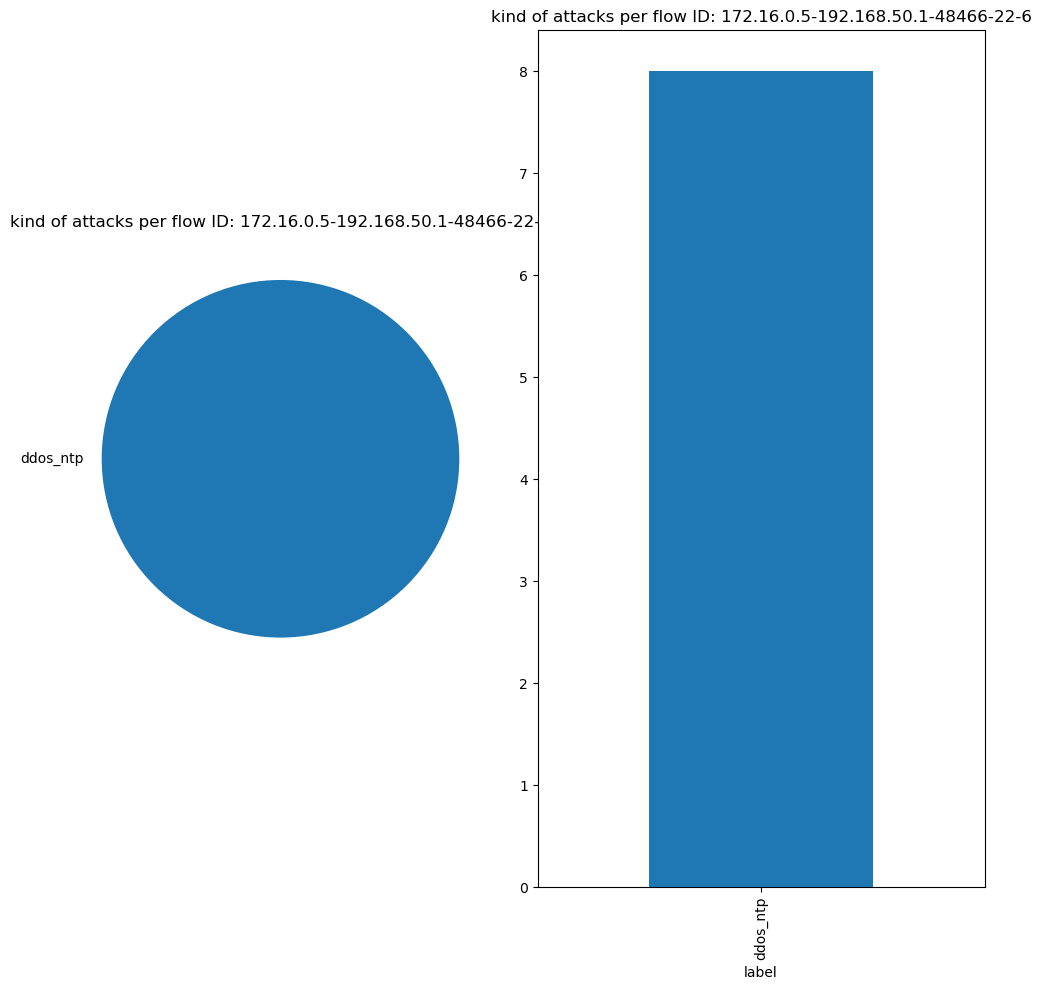

In [15]:
for i, index in enumerate(df_flow_id.index[:3]):
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    mask_index = operational_df['Flow ID'] == index
    df_plot = operational_df[mask_index].groupby('label').count().sort_values(by='Flow ID', ascending=False)['Flow ID']
    df_plot.plot(kind='pie', title= f'kind of attacks per flow ID: {index}', ax=ax[0])
    ax[0].set_ylabel('')
    df_plot.plot(kind='bar', title= f'kind of attacks per flow ID: {index}', ax=ax[1])
    plt.tight_layout()



Analysis of the top 10 common link (Flow ID, Source Port, Destination Port) and the relative attack (the benign flow has been removed) based on the number of packets exchanged

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


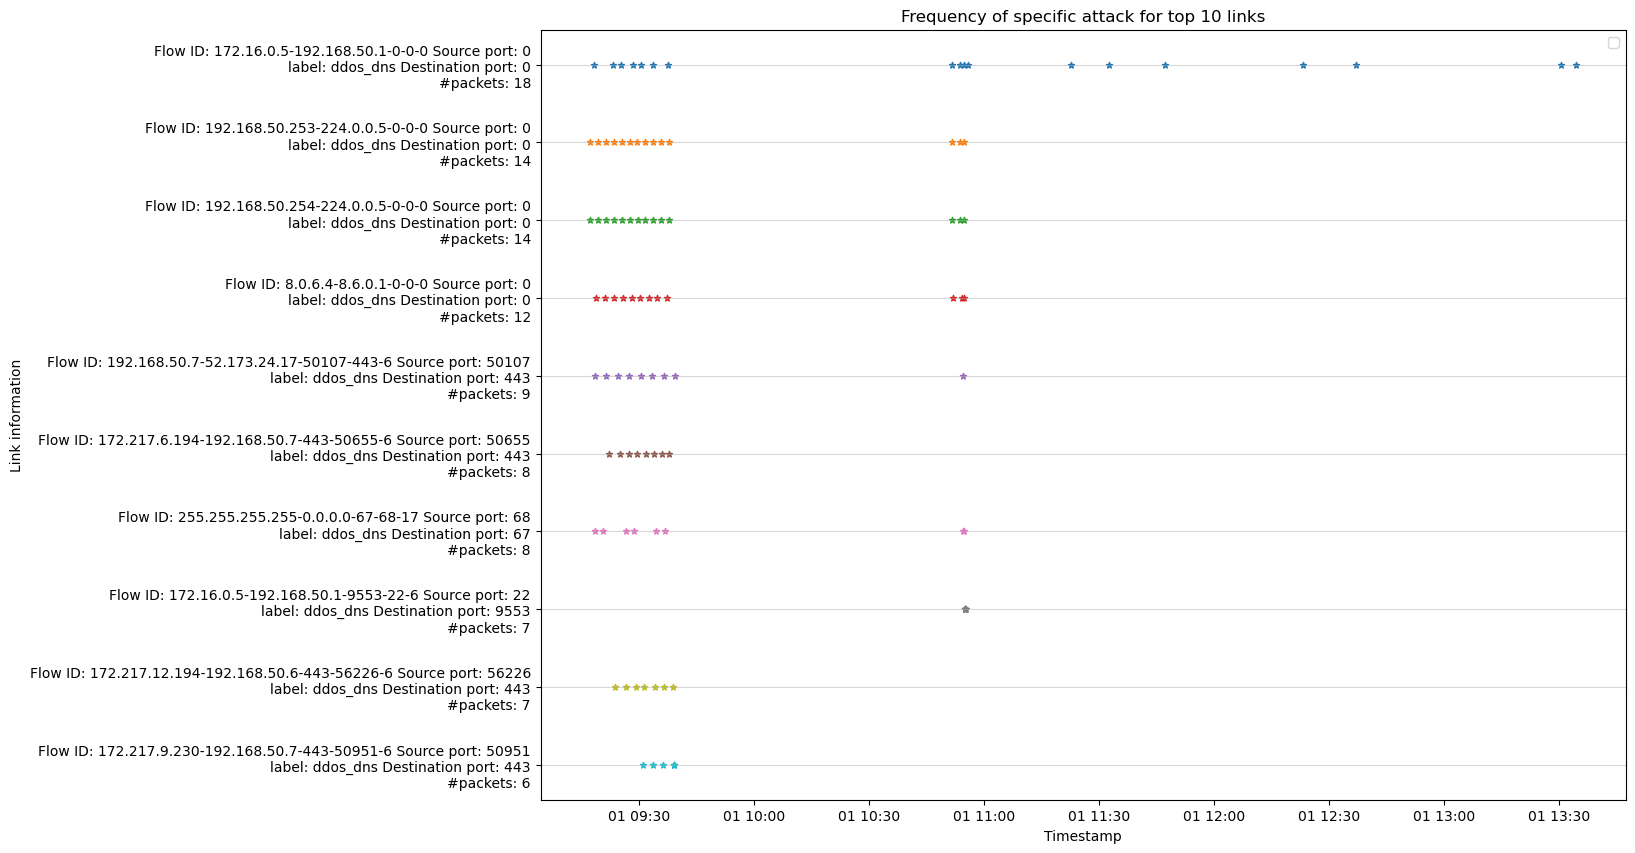

In [58]:
top_10_link = operational_df[operational_df['label'] != 'benign'].groupby(['Flow ID', 'label', ' Source Port', ' Destination Port']).count().sort_values(by=' Source IP', ascending=False).index[:10]
plt.figure(figsize=(14, 10))
ytick_labels = []
for n, link in enumerate(top_10_link):
    flow_id = link[0]
    flow_type = link[1]
    src_port = link[2]
    dst_port = link[3]
    df_link = operational_df[
        (operational_df['Flow ID'] == flow_id) &
        (operational_df[' Source Port'] == src_port) &
        (operational_df['label'] == flow_type) &
        (operational_df[ ' Destination Port'] == dst_port)
    ]
    plt.scatter(
        df_link.index,
        [10-n for _ in range(len(df_link))],
        s = 20, 
        marker = '*'
    )
    # create the label of each link for y-axis
    ytick_label = f'Flow ID: {flow_id} ' + \
                  f'Source port: {src_port}\n' + \
                  f'label: {flow_type} ' + \
                  f'Destination port: {dst_port}\n' + \
                  f'#packets: {len(df_link)}'
    ytick_labels.append(ytick_label)
plt.xlabel('Timestamp') 
plt.ylabel('Link information')
# the first list the the location of the label
# the second list is the label you want to assign to each location
plt.yticks([x for x in range(10,0,-1)], ytick_labels) 
plt.title('Frequency of specific attack for top 10 links')
plt.grid(axis='y', alpha=0.5)
plt.legend()
plt.show()

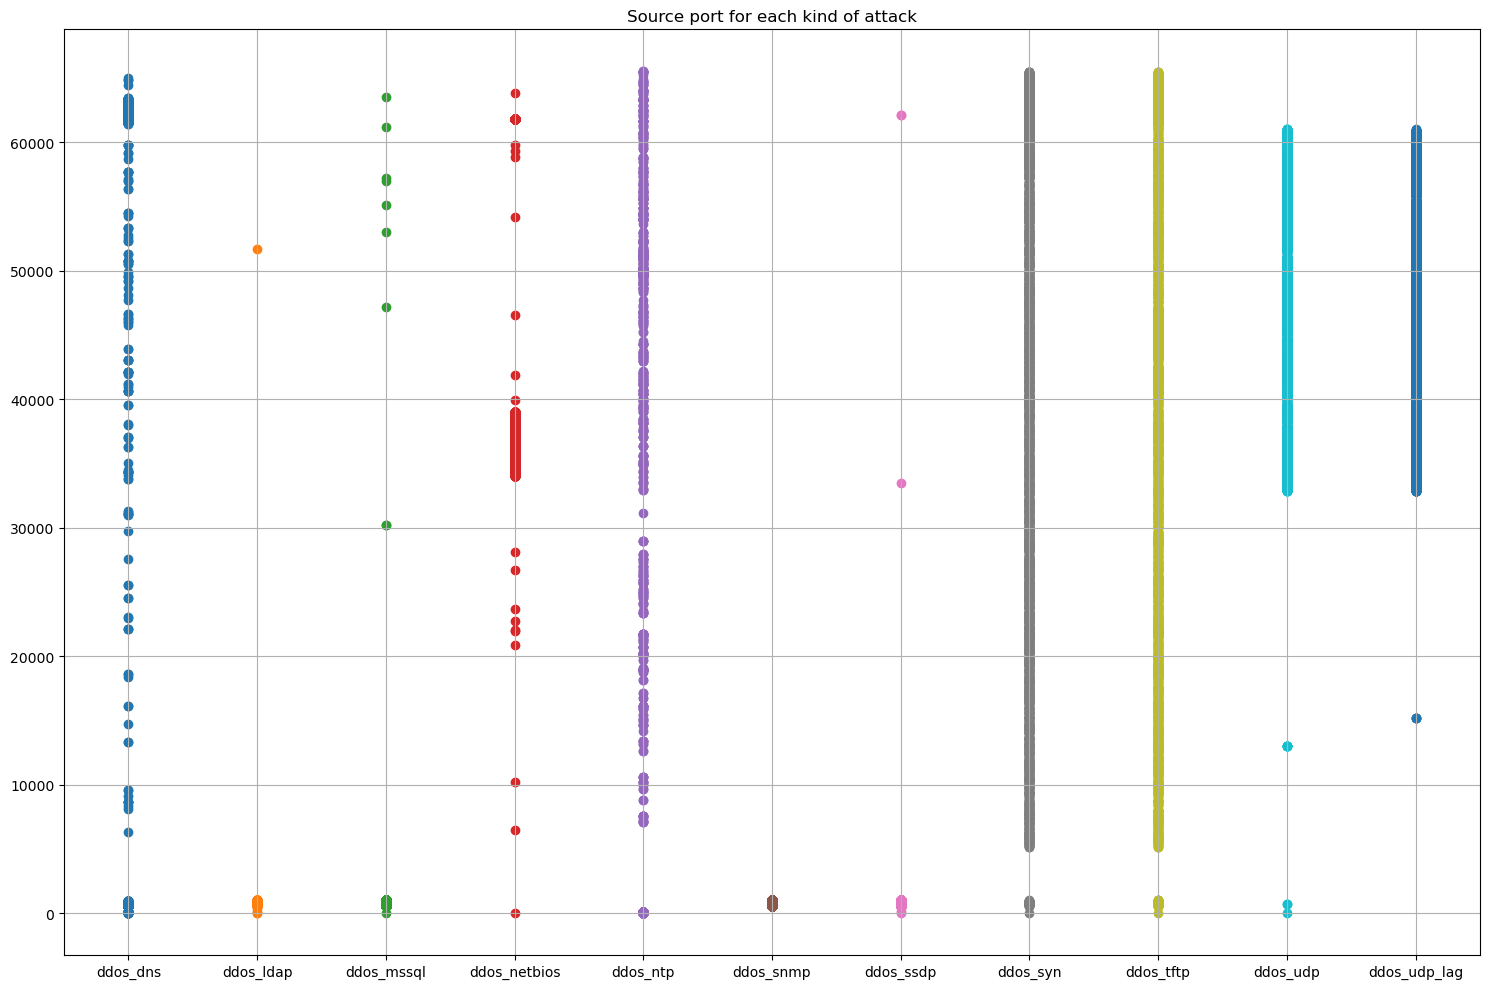

In [4]:
operational_df = ddos_data.copy()
operational_df[' Timestamp'] = pd.to_datetime(operational_df[' Timestamp'])
operational_df.set_index(' Timestamp', inplace=True)
mask_malicious = operational_df['label'] != 'benign'
df_result = operational_df[mask_malicious]
ax, figure = plt.subplots(figsize=(15,10))
labels = df_result.groupby('label').count().index
for attack in labels:
    mask_at = df_result['label'] == attack
    plt.scatter(data=df_result[mask_at], x='label', y=' Source Port')
plt.title('Source port for each kind of attack')
plt.grid()
plt.tight_layout()
plt.show()
    

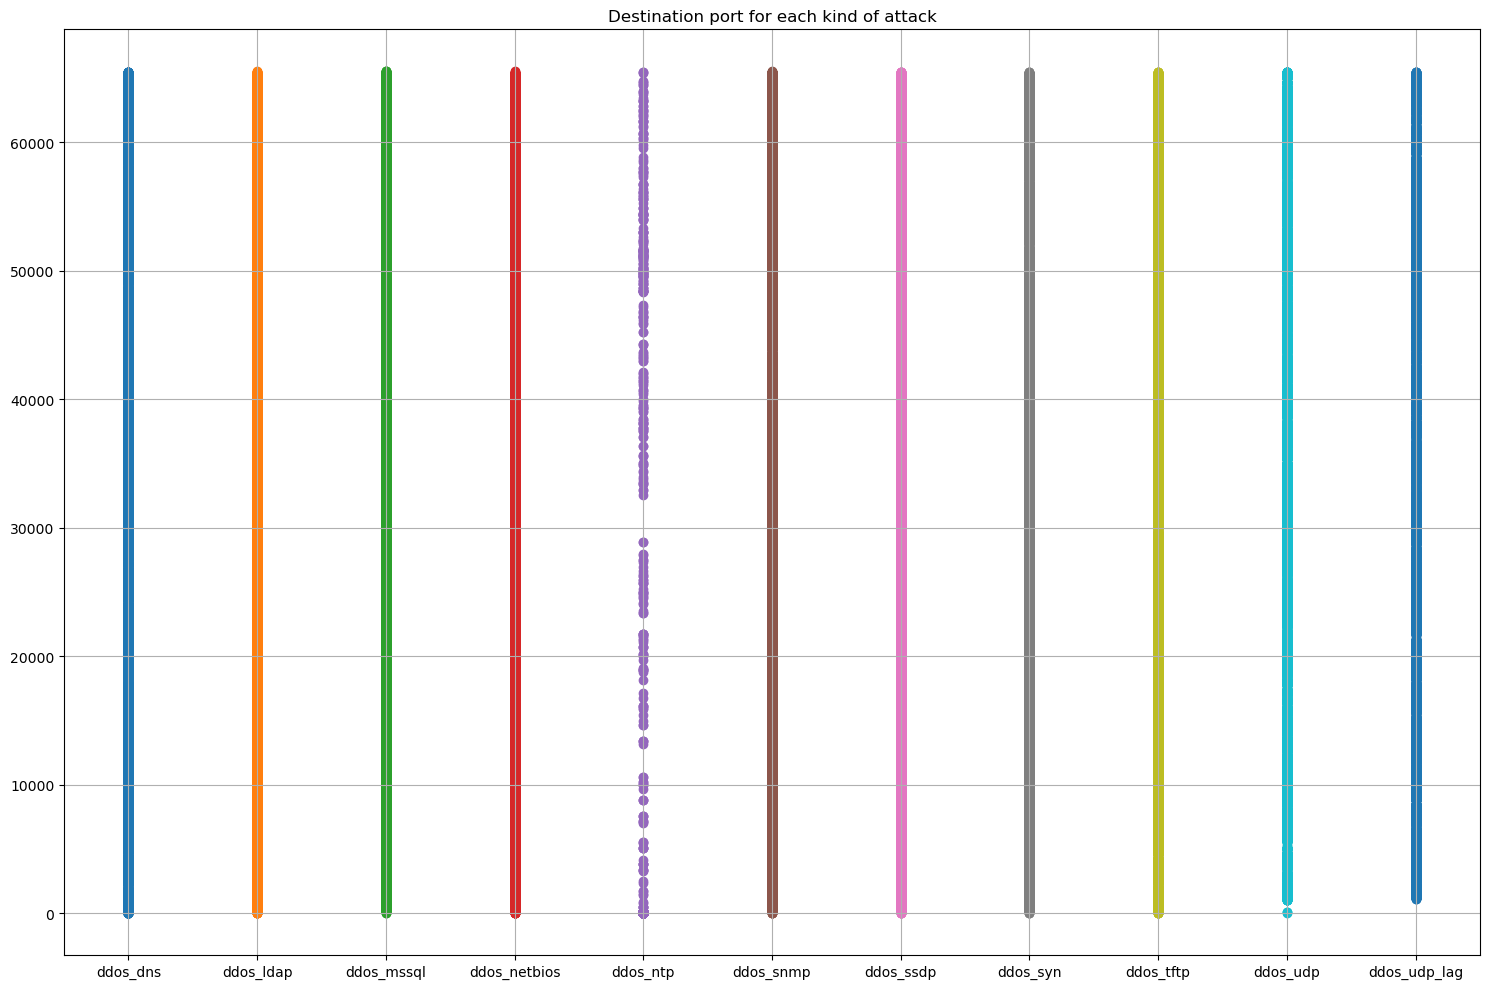

In [5]:
operational_df = ddos_data.copy()
operational_df[' Timestamp'] = pd.to_datetime(operational_df[' Timestamp'])
operational_df.set_index(' Timestamp', inplace=True)
mask_malicious = operational_df['label'] != 'benign'
df_result = operational_df[mask_malicious]
ax, figure = plt.subplots(figsize=(15,10))
labels = df_result.groupby('label').count().index
for attack in labels:
    mask_at = df_result['label'] == attack
    plt.scatter(data=df_result[mask_at], x='label', y=' Destination Port')
plt.title('Destination port for each kind of attack')
plt.grid()
plt.tight_layout()
plt.show()
    

Evauluating Packet length for each different kind of flow (attack or benign) 

               count         mean          std    min     25%     50%     75%  \
label                                                                           
benign        5658.0   891.858607  4342.315612    0.0     0.0    66.0   104.0   
ddos_ldap     5928.0  2929.207152   193.201216    0.0  2944.0  2944.0  2944.0   
ddos_mssql    5911.0  2931.977669   173.100238    0.0  2944.0  2944.0  2944.0   
ddos_netbios  5830.0  1137.999314   447.887761    0.0   874.0   966.0  1206.0   
ddos_ntp       986.0   409.253550   763.397081    0.0     0.0     0.0   560.0   
ddos_snmp     5984.0   459.737634    52.046688  314.0   458.0   458.0   458.0   
ddos_ssdp     5970.0  2884.428811   207.364519    0.0  2896.0  2944.0  2944.0   
ddos_syn      5480.0     0.010219     0.756481    0.0     0.0     0.0     0.0   
ddos_tftp     5261.0     0.045619     1.910002    0.0     0.0     0.0     0.0   
ddos_udp      5876.0  1349.083730   979.513616    0.0   766.0  1398.0  1438.0   
ddos_udp_lag  5986.0  1303.9

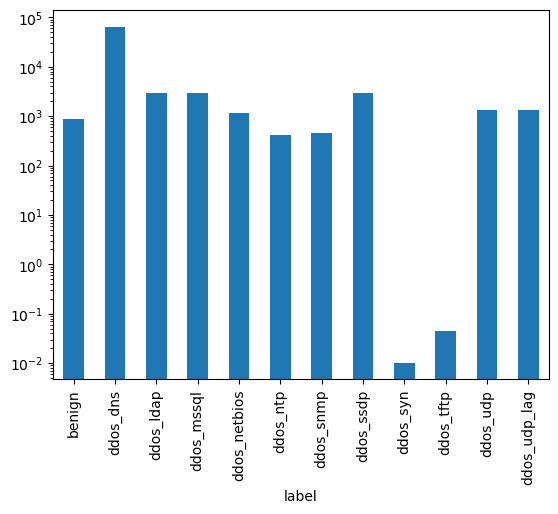

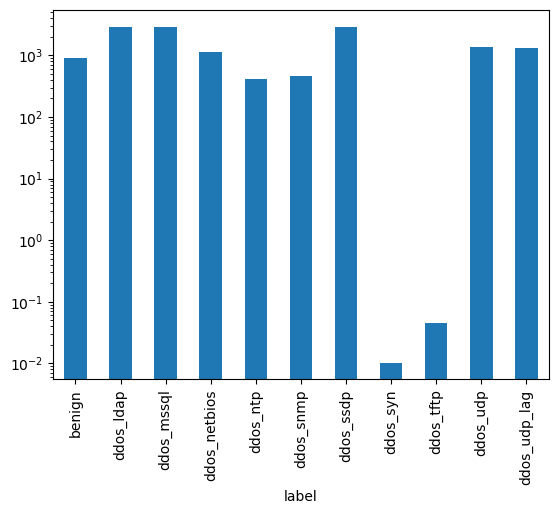

In [44]:
fig, ax = plt.subplots()
grouped_df = operational_df.groupby('label')
grouped_df['Total Length of Fwd Packets'].mean().plot(kind='bar')
plt.yscale('log')
fig, ax = plt.subplots()
grouped_df = operational_df[operational_df['label'] != 'ddos_dns'].groupby('label')
grouped_df['Total Length of Fwd Packets'].mean().plot(kind='bar')
plt.yscale('log')


Inbound anlysis

<Axes: xlabel='label'>

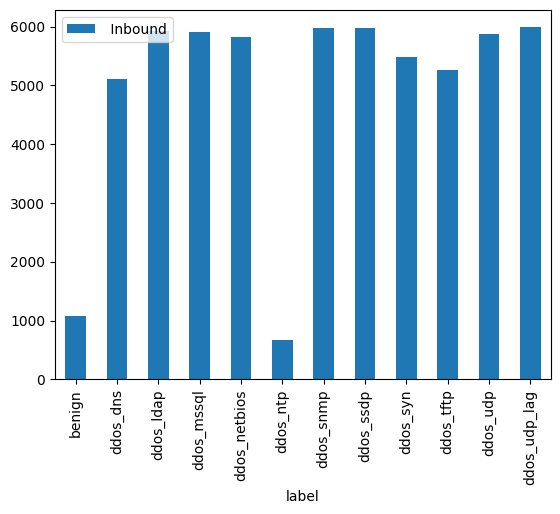

In [4]:
mask_inbound = operational_df[' Inbound'] != 0
at_inbound_df = operational_df[mask_inbound]
at_inbound_df[[' Inbound', 'label']].groupby('label').count().plot(kind='bar')

<Axes: xlabel='label'>

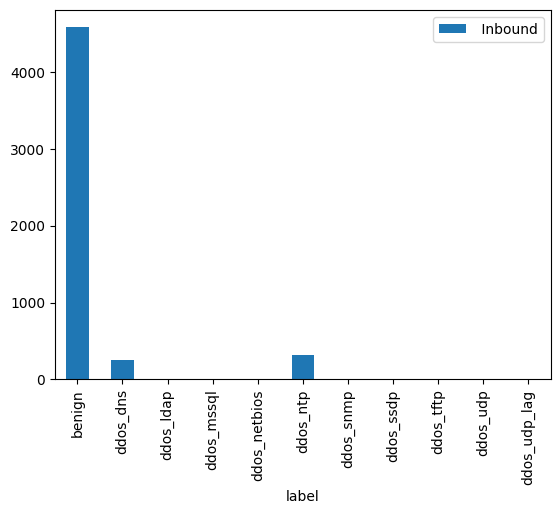

In [5]:
mask_inbound = operational_df[' Inbound'] != 1
at_inbound_df = operational_df[mask_inbound]
at_inbound_df[[' Inbound', 'label']].groupby('label').count().plot(kind='bar')

PCA 

/tmp/ipykernel_13694/4215780235.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr().abs().round(2)


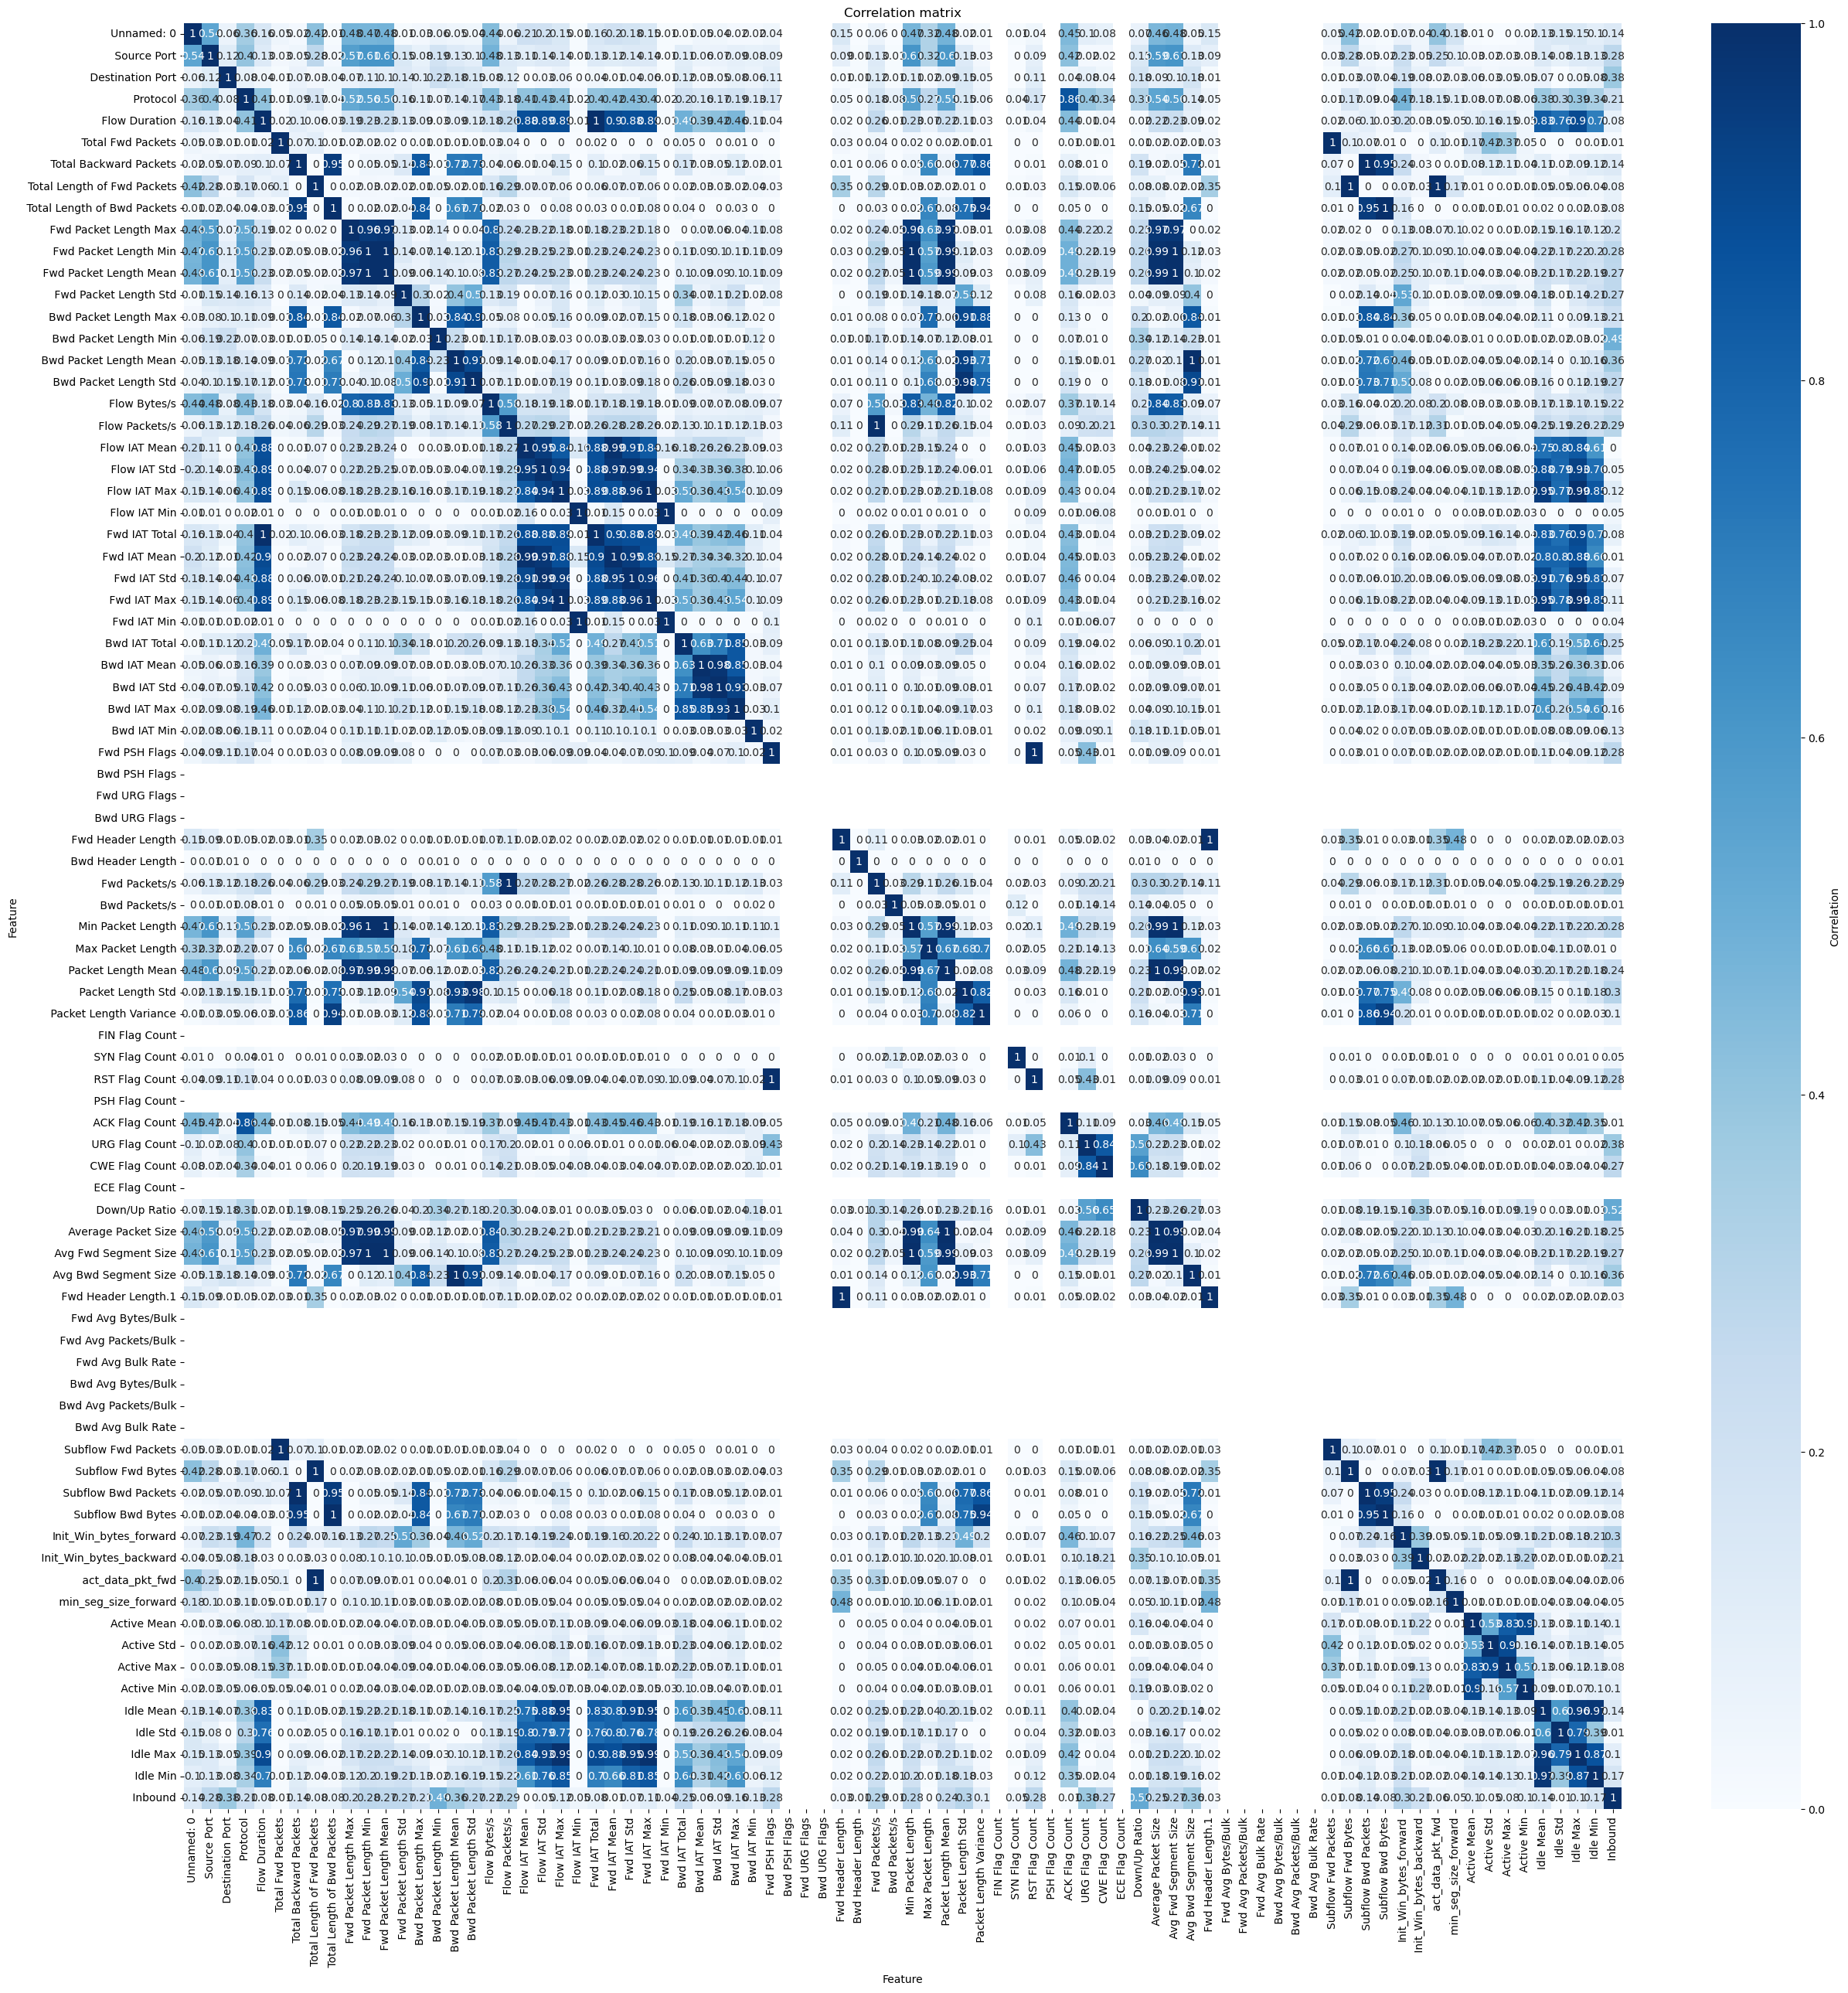

In [45]:
from sklearn.preprocessing import StandardScaler
df = ddos_data.copy()
df.set_index(' Timestamp', inplace=True)
scaler = StandardScaler()
column_to_remove = ['Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP', 'label']
df[df.columns.drop(column_to_remove)] = scaler.fit_transform(df[df.columns.drop(column_to_remove)])
df_scaled = df.copy()
correlation_matrix = df.corr().abs().round(2)
plt.figure(figsize=(30,30))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, vmin=0, vmax=1, cbar_kws={'label':'Correlation'})
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

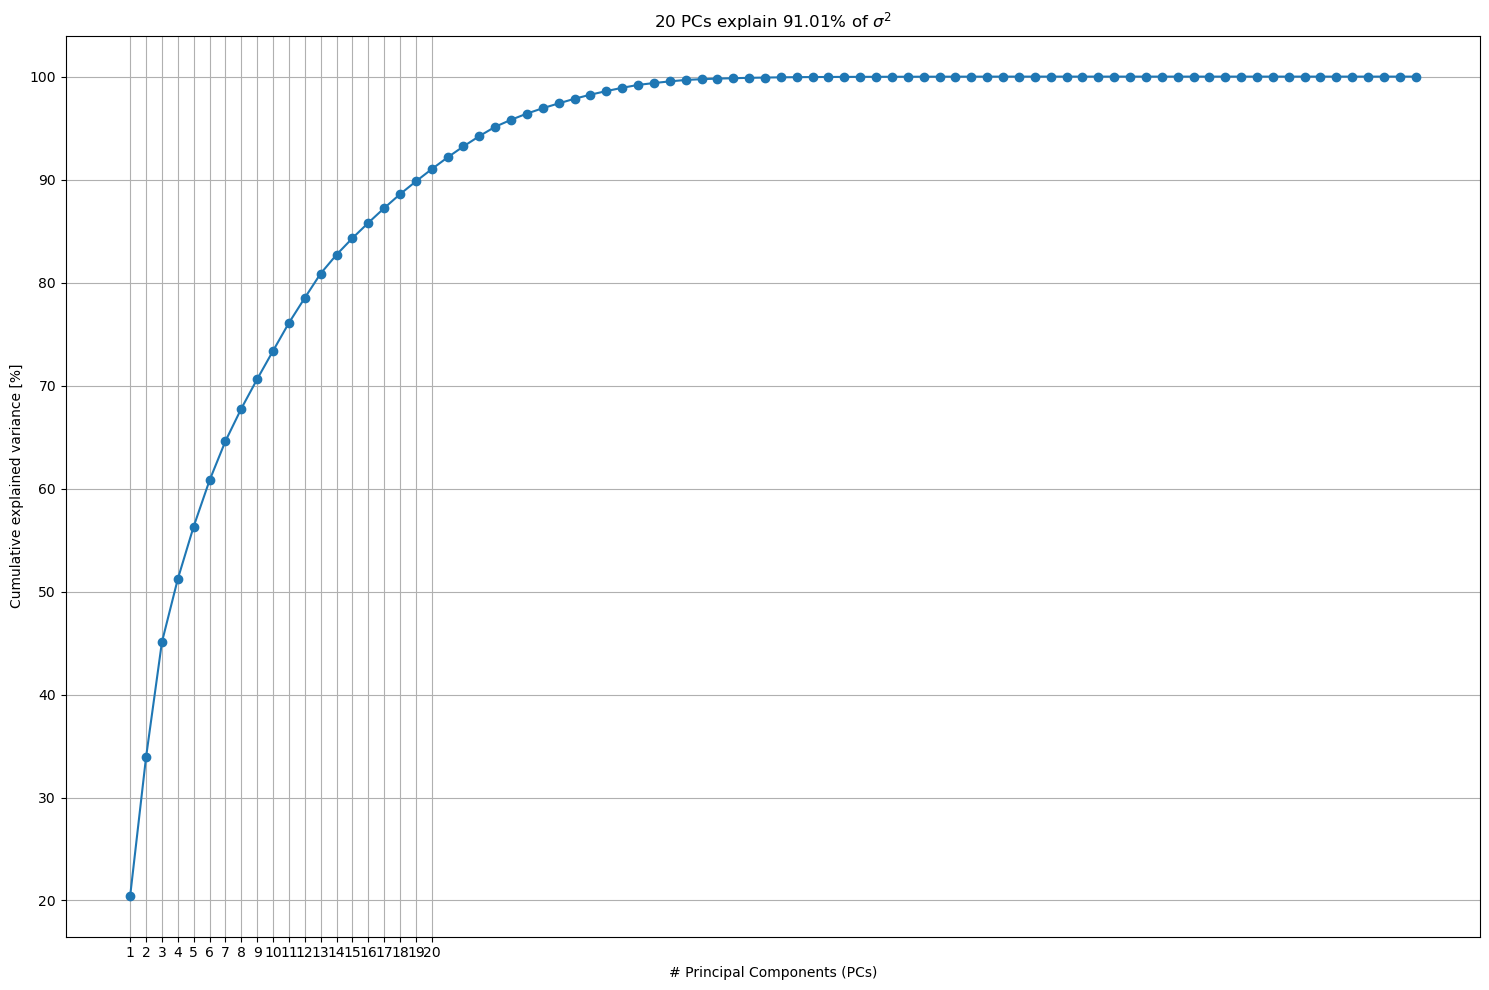

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(random_state=15)
pca.fit(df_scaled.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']))

explained_variance = pca.explained_variance_ratio_
cumul_exp_var = np.cumsum(explained_variance)
perc_cumul_exp_var = cumul_exp_var*100

plt.figure(figsize=(15,10))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(20)], [i for i in range (1,21)])
plt.grid()
plt.title(f'20 PCs explain {round(perc_cumul_exp_var[19], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()

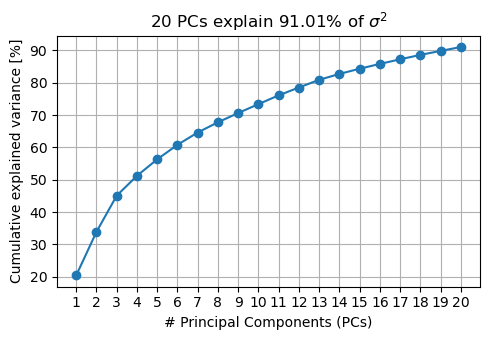

In [47]:
pca = PCA(n_components=20, random_state=15)
pca.fit(df_scaled.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']))
pca_result = pca.transform(df_scaled.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']))

pca_df = pd.DataFrame(pca_result, columns=['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20'])
explained_variance = pca.explained_variance_ratio_

# evaluate the total dataset variability while increasing the variables
cumul_exp_var = np.cumsum(explained_variance)

# percentage value to better understand the best number of components
perc_cumul_exp_var = cumul_exp_var * 100

# make the plot of cumulative explained variance wrt number of components
plt.figure(figsize=(5, 3.5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(20)], [i for i in range(1,21)])
plt.grid()
plt.title(f'20 PCs explain {round(perc_cumul_exp_var[19], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()

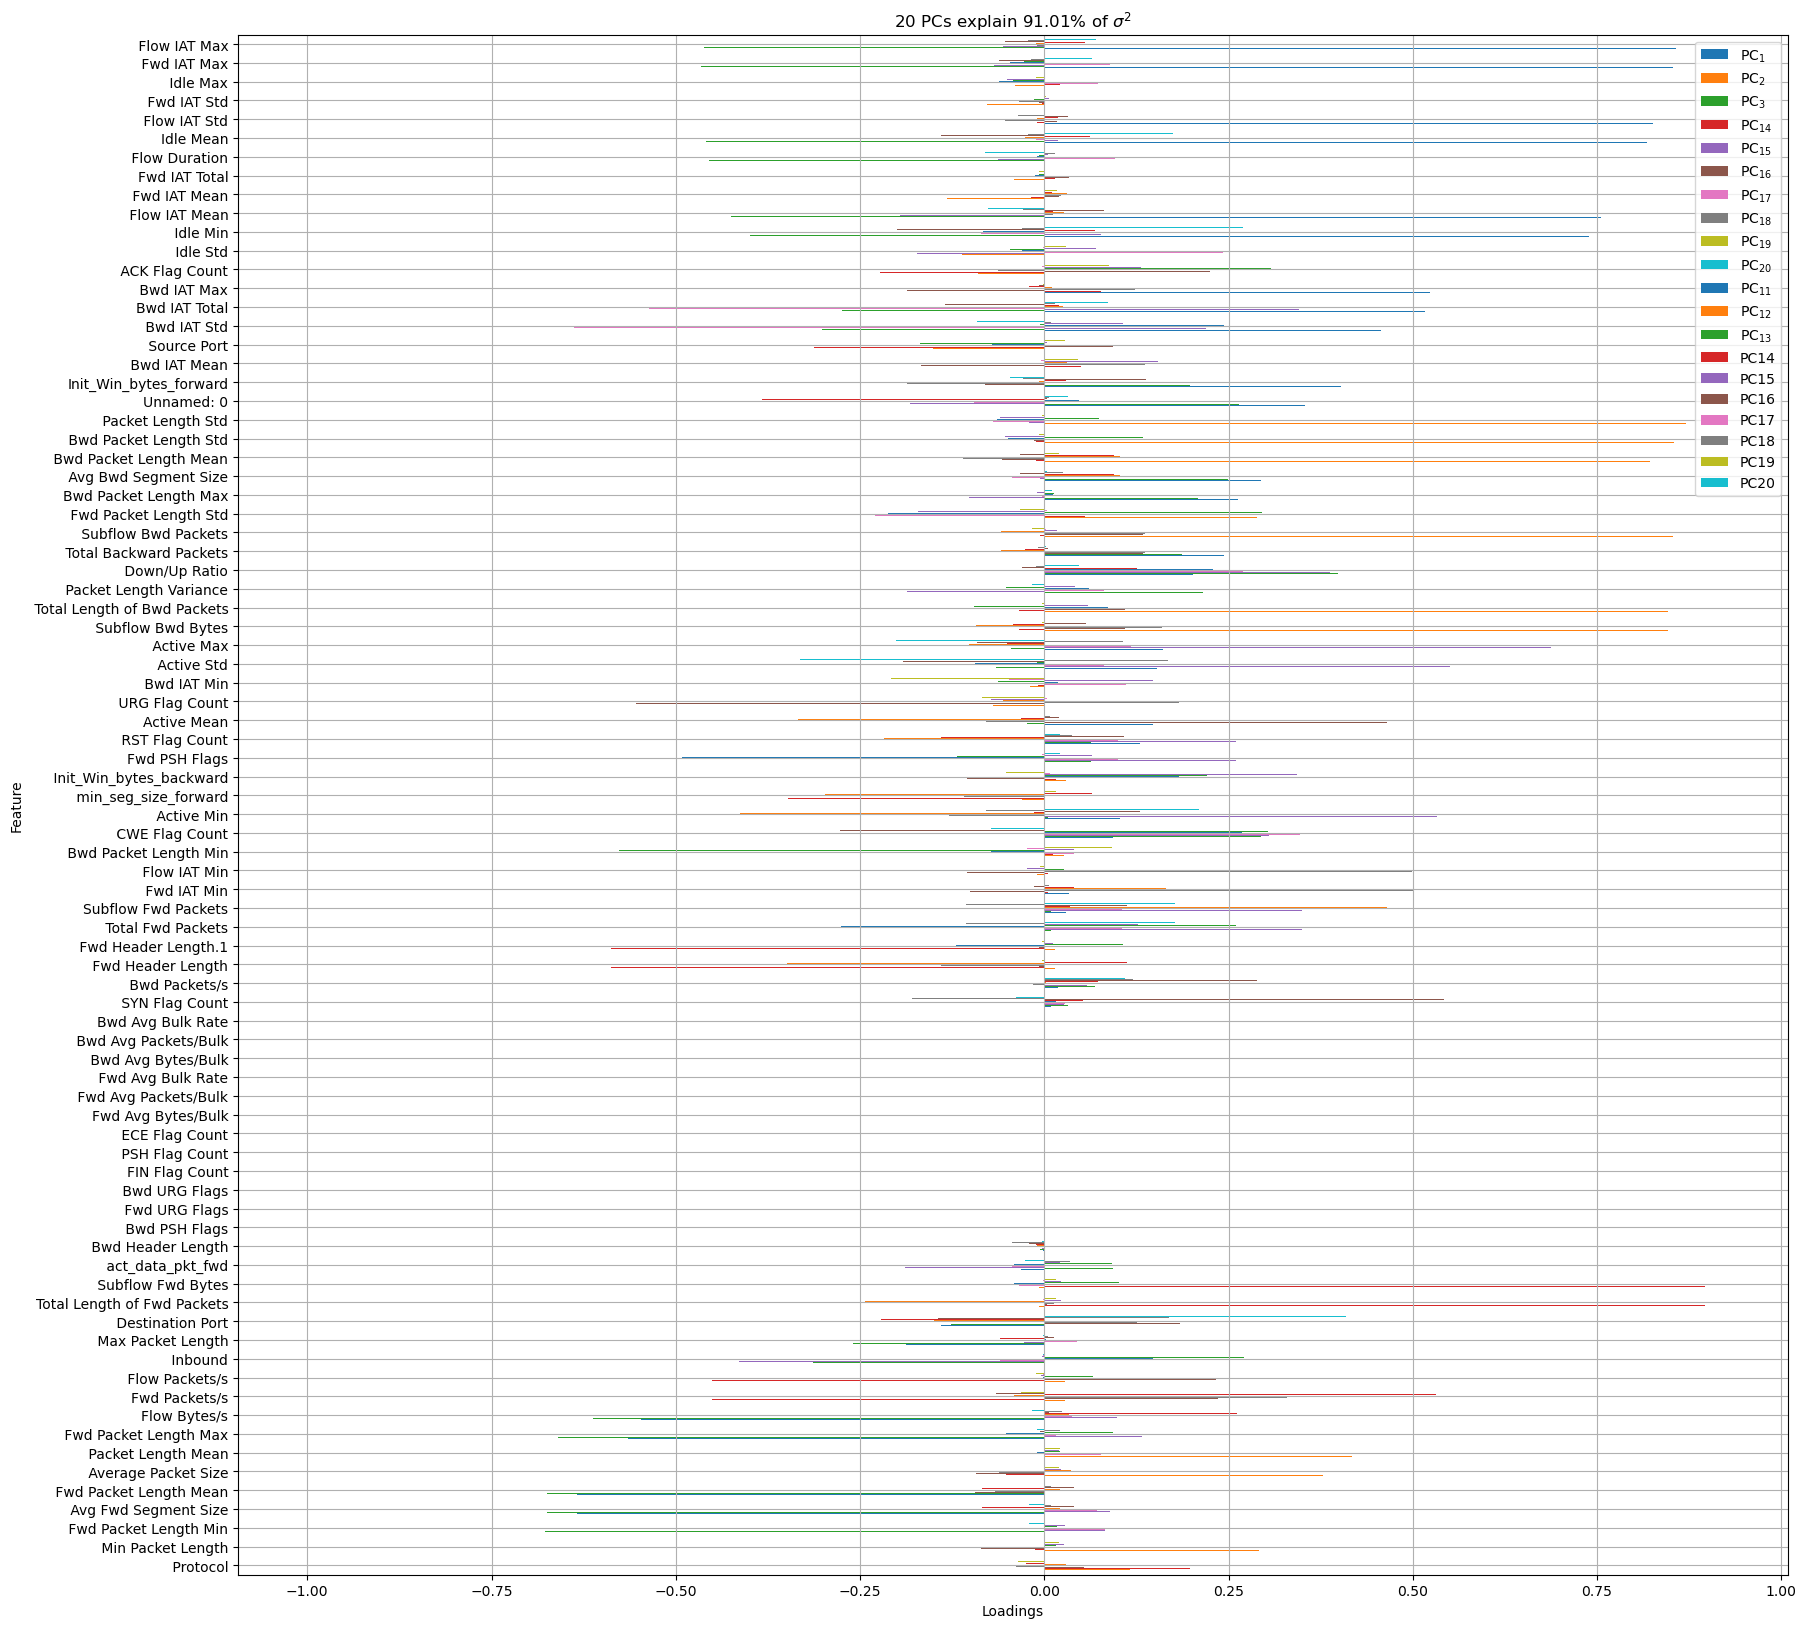

In [48]:
loadings = pd.DataFrame(
    data = pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns = [f'PC{i}' for i in range(1, 21)],
    index = df_scaled.drop(columns=['label', 'Flow ID', ' Source IP', ' Destination IP', 'SimillarHTTP']).columns
)

plt.figure(figsize=(20,20))
loadings = loadings[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20']]
loadings.sort_values(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
                       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20']).rename(columns={'PC1':'PC$_{1}$', 'PC2':'PC$_{2}$',
        'PC3':'PC$_{3}$', 'PC4':'PC$_{4}$', 'PC5':'PC$_{5}$', 'PC6':'PC$_{6}$', 'PC7':'PC$_{7}$', 'PC8':'PC$_{8}$', 'PC9':'PC$_{9}$', 'PC10':'PC$_{10}$', 'PC11':'PC$_{11}$', 'PC12':'PC$_{12}$',
        'PC13':'PC$_{13}$', 'PC4':'PC$_{14}$', 'PC5':'PC$_{15}$', 'PC6':'PC$_{16}$', 'PC7':'PC$_{17}$', 'PC8':'PC$_{18}$', 'PC9':'PC$_{19}$', 'PC10':'PC$_{20}$'}).plot.barh(ax=plt.gca())
plt.grid()
plt.xlabel('Loadings')
plt.ylabel('Feature')
plt.title(f'20 PCs explain {round(perc_cumul_exp_var[19], 2)}% of $\sigma^2$')
plt.show()

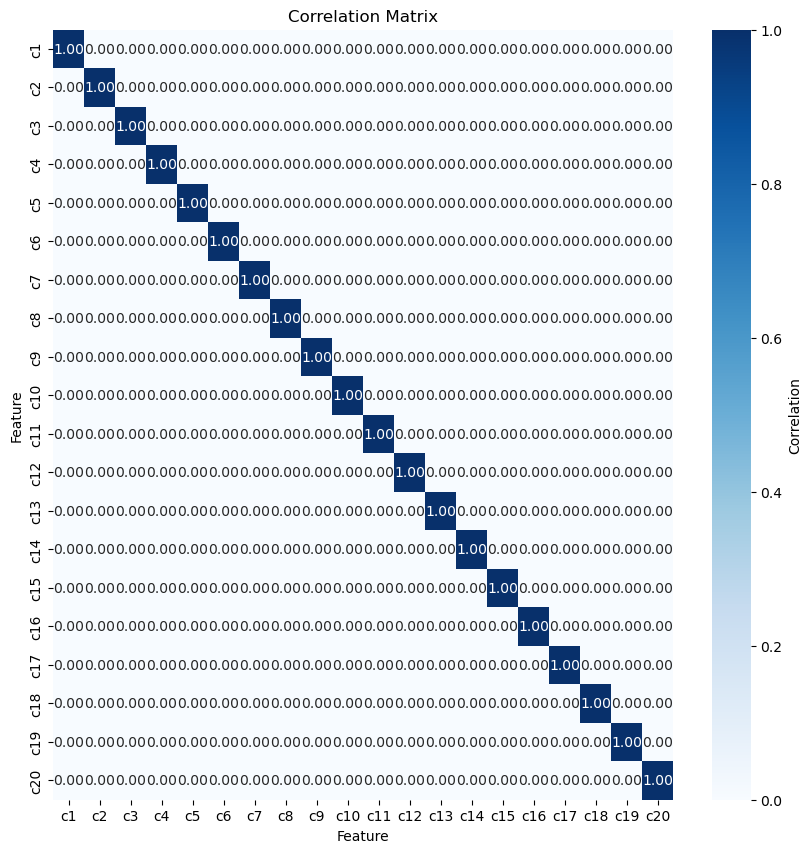

In [49]:
pca_correlation_matrix = pca_df.corr().abs()

plt.figure(figsize=(10,10))
sns.heatmap(pca_correlation_matrix, cmap='Blues', annot=True, vmin=0, vmax=1, cbar_kws={'label':'Correlation'}, fmt='.2f')
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation Matrix')
plt.show()

Section 2 Supervised learning

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

operational_df = ddos_data.copy()
operational_df['label'] = pd.Categorical(operational_df['label']).codes

X_train, X_test, y_train, y_test = train_test_split(
    pca_df[pca_df.columns],
    operational_df['label'],
    stratify=operational_df['label'],
    train_size=0.7,
    random_state=15
)

model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train, y_train)

model_RFC = RandomForestClassifier()
model_RFC.fit(X_train, y_train)

model_SVC = SVC()
model_SVC.fit(X_train, y_train)

y_pred_train_KNN = model_KNN.predict(X_train)
y_pred_test_KNN = model_KNN.predict(X_test)

y_pred_train_RFC = model_RFC.predict(X_train)
y_pred_test_RFC = model_RFC.predict(X_test)

y_pred_train_SVC = model_SVC.predict(X_train)
y_pred_test_SVC = model_SVC.predict(X_test)

model: KNN
train set predictions evaluation
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3961
           1       0.98      0.96      0.97      3758
           2       0.97      0.97      0.97      4149
           3       0.98      0.98      0.98      4138
           4       0.99      0.99      0.99      4081
           5       0.95      0.97      0.96       690
           6       1.00      1.00      1.00      4189
           7       0.99      1.00      1.00      4179
           8       0.99      0.99      0.99      3836
           9       0.99      0.99      0.99      3683
          10       1.00      1.00      1.00      4113
          11       1.00      1.00      1.00      4190

    accuracy                           0.99     44967
   macro avg       0.99      0.99      0.99     44967
weighted avg       0.99      0.99      0.99     44967

test set predictions evaluation
              precision    recall  f1-score   support

  

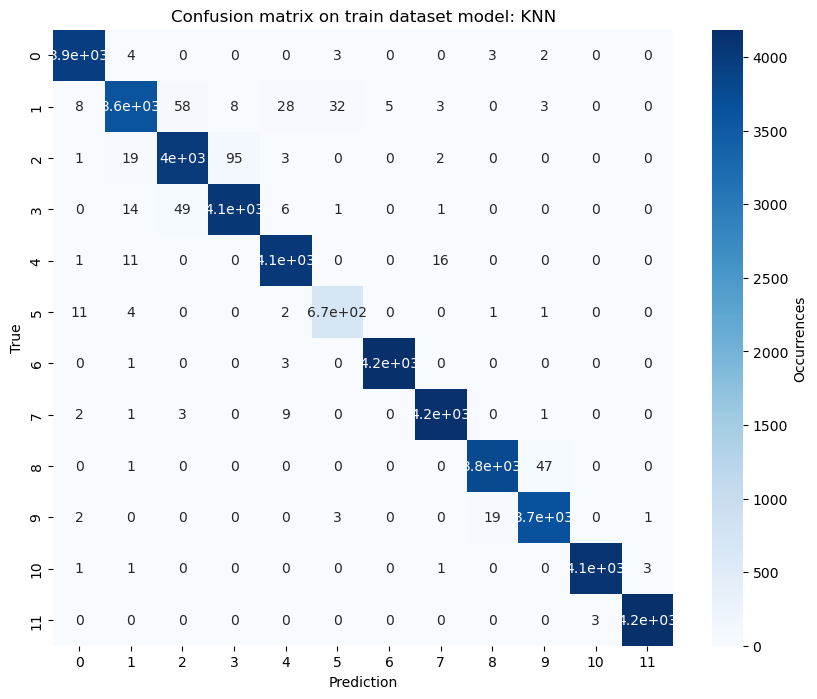

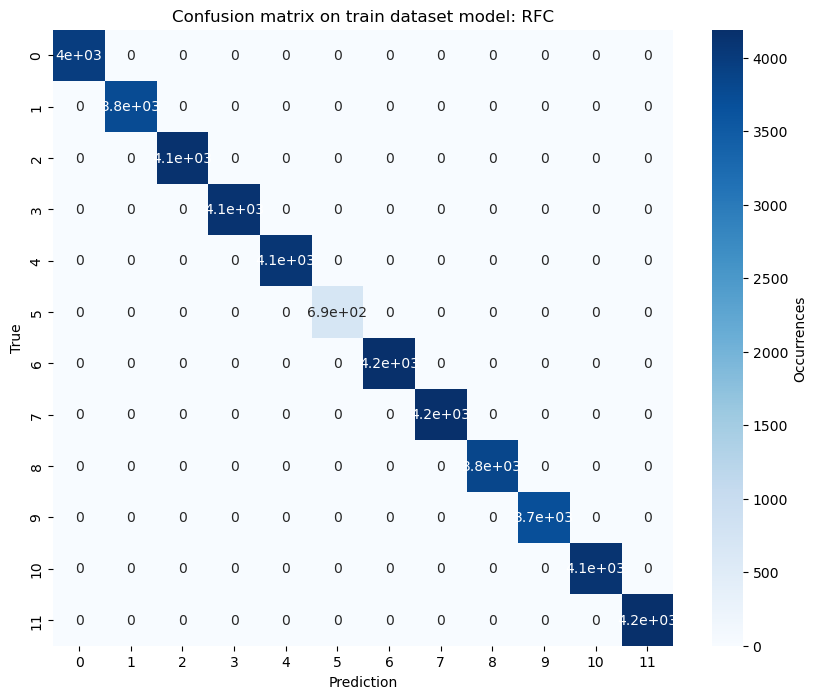

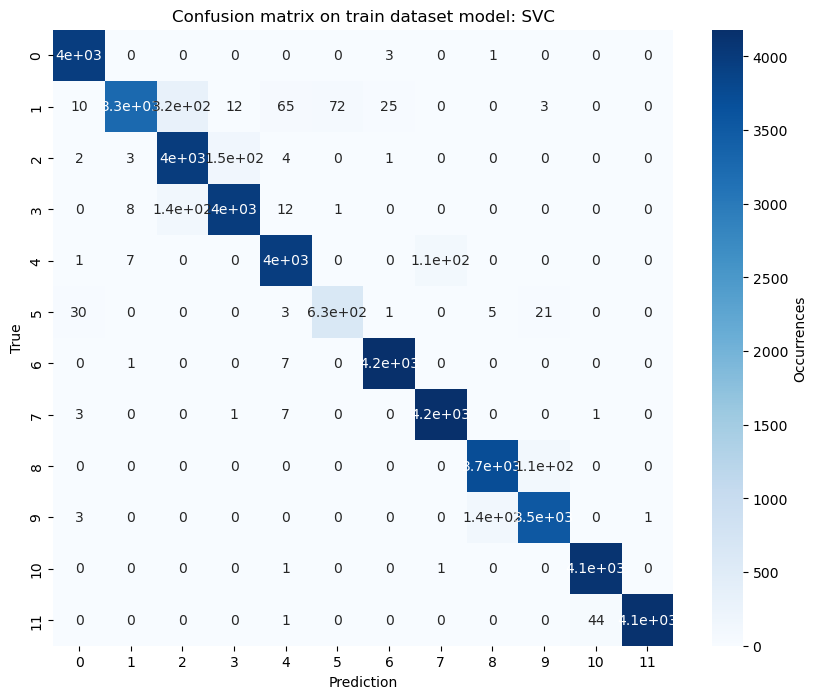

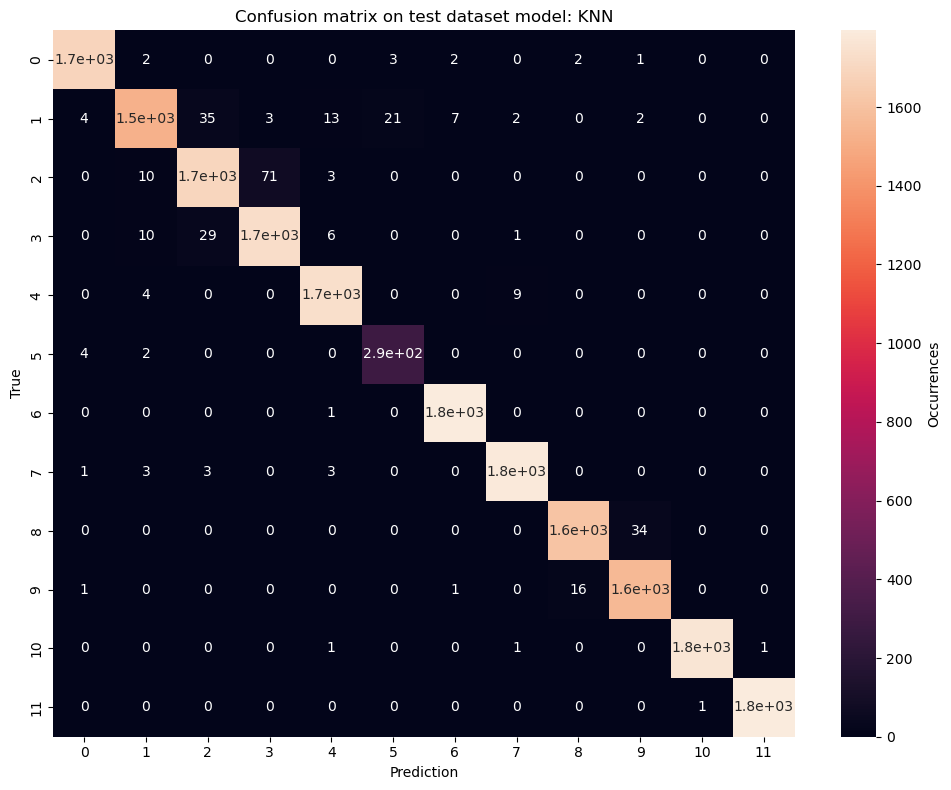

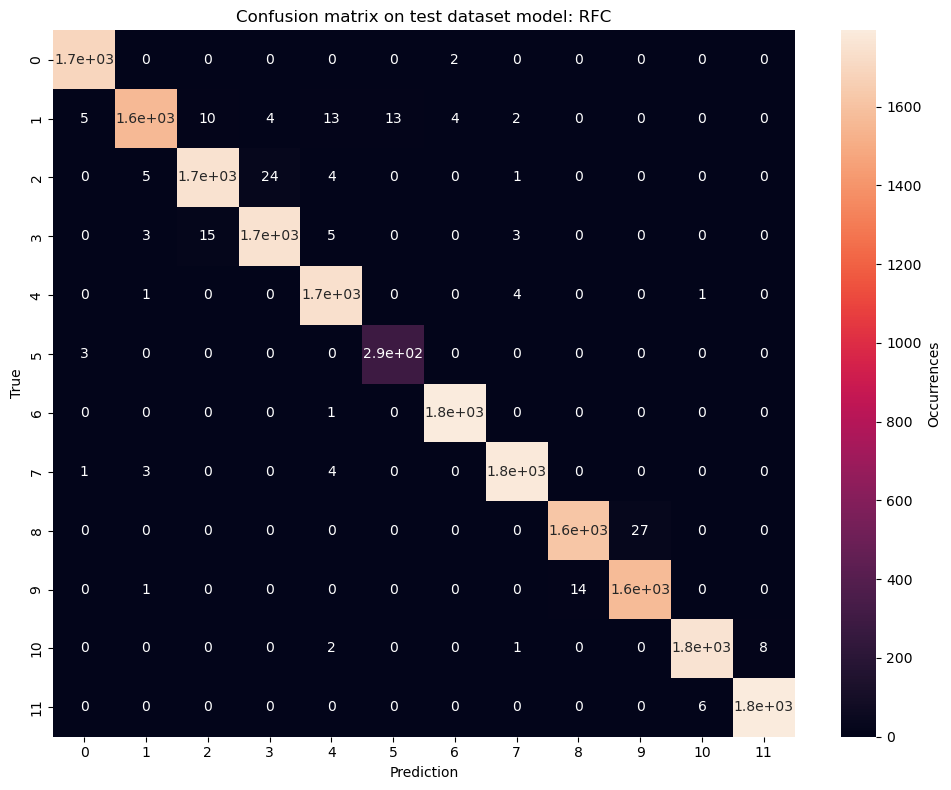

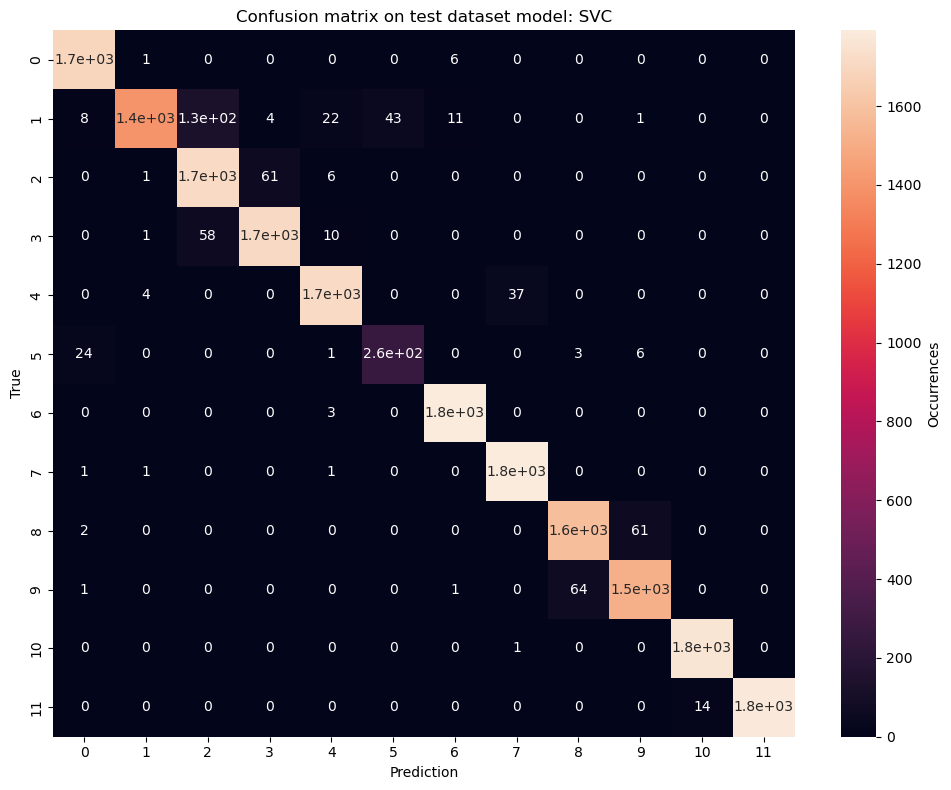

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
print('model: KNN')
print('train set predictions evaluation')
print(classification_report(y_train, y_pred_train_KNN))
print('test set predictions evaluation')
print(classification_report(y_test, y_pred_test_KNN))

print('model: RFC')
print('train set predictions evaluation')
print(classification_report(y_train, y_pred_train_RFC))
print('test set predictions evaluation')
print(classification_report(y_test, y_pred_test_RFC))

print('model: SVC')
print('train set predictions evaluation')
print(classification_report(y_train, y_pred_train_SVC))
print('test set predictions evaluation')
print(classification_report(y_test, y_pred_test_SVC))

train_predicted = [y_pred_train_KNN, y_pred_train_RFC, y_pred_train_SVC]
test_predicted = [y_pred_test_KNN, y_pred_test_RFC, y_pred_test_SVC]
models = ["KNN", "RFC", "SVC"]

for i, label in enumerate(train_predicted):    
    # get the confusion matrix of test set
    confusion_test = confusion_matrix(y_train, label).round(2)
    
    # visualize the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_test, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'})
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'Confusion matrix on train dataset model: {models[i]}')
    plt.show()

for i, label in enumerate(test_predicted):    
    # get the confusion matrix of test set
    confusion_test = confusion_matrix(y_test, label)
    
    # visualize the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_test,  annot=True, cbar_kws={'label':'Occurrences'})
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'Confusion matrix on test dataset model: {models[i]}')
    plt.tight_layout()
    plt.show()

In [55]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

for i, label in enumerate(train_predicted):
    print(f'Mean squared error for model: {models[i]} on train dataset')
    print(mean_squared_error(y_train, label))
    print(f'Mean absolute error for model: {models[i]} on train dataset')
    print(mean_absolute_error(y_train, label))

for i, label in enumerate(test_predicted):
    print(f'Mean squared error for model: {models[i]} on test dataset')
    print(mean_squared_error(y_test, label))
    print(f'Mean absolute error for model: {models[i]} on test dataset')
    print(mean_absolute_error(y_test, label))

Mean squared error for model: KNN on train dataset
0.07810171903840595
Mean absolute error for model: KNN on train dataset
0.022594346965552518
Mean squared error for model: RFC on train dataset
0.0
Mean absolute error for model: RFC on train dataset
0.0
Mean squared error for model: SVC on train dataset
0.1463072920141437
Mean absolute error for model: SVC on train dataset
0.05241621633642449
Mean squared error for model: KNN on test dataset
0.11000415110004151
Mean absolute error for model: KNN on test dataset
0.03227480282274803
Mean squared error for model: RFC on test dataset
0.06761104192611042
Mean absolute error for model: RFC on test dataset
0.020288501452885015
Mean squared error for model: SVC on test dataset
0.17216687422166874
Mean absolute error for model: SVC on test dataset
0.056870070568700706
